In [1]:
# # load dataset

# from datasets import load_dataset
# from tokenizers import ByteLevelBPETokenizer

# tokenizer = ByteLevelBPETokenizer()
# dataset = load_dataset("roneneldan/TinyStories")

# # Specify the split you want to save (e.g., "train", "validation", "test")
# split = "train"

# # Get the desired split from the dataset
# subset = dataset[split]

# # Save the subset to a text file
# subset.to_csv("tinystories-train.txt", sep="\t", index=False)


In [2]:
#----- imports --------

import tqdm
import torch
from torch import nn
import wandb
import os
import tokenizers
from matplotlib import pyplot as plt
import numpy as np
import json


device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 1e-3,
    "sae_learning_rate": 5e-5,
    "model_embedding_layer": 6,
    "eval_interval": 500,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 8,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "n_layers": 12,
    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v


#wandb.init(
#    project = "tinystories",
#    config = config,
#)

In [3]:

with open('tinystories-train.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1916206969


In [5]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    "./tiny-stories-bpe-vocab.json", 
    "./tiny-stories-bpe-merges.txt"
)


In [6]:

def encode(text):
    return tokenizer.encode(text).ids
def decode(encoded_text):
    return tokenizer.decode(encoded_text)

from tqdm import tqdm

def batch_encode(text, batch_size):
    tokens = []
    for i in tqdm(range(0, len(text), batch_size)):
        tokens.extend(encode(text[i:i+batch_size]))
    return tokens


hello_encoded = encode("hello")
print(hello_encoded)
print(decode(hello_encoded))
vocab_size = tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)

[6132]
hello
vocab size:  8192


In [7]:
print("length of dataset in characters: ", len(text[:10000]))
print("length of dataset in tokens: ", len(encode(text[:10000])))
chars_per_token = len(text[:10000]) / len(encode(text[:10000]))
print("characters per token: ", chars_per_token)

length of dataset in characters:  10000
length of dataset in tokens:  2457
characters per token:  4.07000407000407


In [8]:
# load data from tiny-stories-train.pt
data = torch.load('tiny-stories-train.pt', map_location='cuda')[:300000]

tensor_size_mb = data.element_size() * data.nelement() / (1024 ** 2)
print(f"Size of the tensor data: {tensor_size_mb:.2f} MB")


Size of the tensor data: 2.29 MB


In [9]:
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

In [10]:
decode(data[:100].tolist())

'text\n"One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, ""Mom, I found this needle. Can you share it with me and sew my shirt?"" Her mom smiled and said, ""Yes, Lily, we can share the needle and fix'

In [11]:
# torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y

xb, yb = get_batch('train')

for b in range(B):
    for t in range(T): # for each of the characters in the sample
        context = xb[b, :t+1]
        target = yb[b, t]


In [12]:

import torch
import torch.nn as nn
from torch.nn import functional as F
# torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)


In [13]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''
    def __init__(self, H, C, n_heads): # H is head embedding space size, n_heads is number of heads
        super().__init__()
        self.heads = nn.ModuleList([Head(H) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)


    def forward(self,x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return x

In [14]:
head = MultiHeadAttention(H, C, n_heads)
head.heads[0].forward(x).shape


torch.Size([8, 256, 32])

In [15]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
        )

    def forward(self, x):
        return self.net(x)

In [16]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [17]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [18]:
class GPT(nn.Module):

    def __init__(self, n_layers):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, C) 
        self.position_embedding_table = nn.Embedding(T, C)
        self.lm_head = nn.Linear(C, vocab_size)
        self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
    
    def forward(self, idx, targets=None, return_residuals=None):
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = token_emb + pos_emb # token identities and positions contained

        if return_residuals == "first_embedding":
            return x

        def excess_kurtosis(emb):
            mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
            std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

            centralized = emb - mean #BxTxC
            fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
            kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
            # view as a 1d vector
            kurtosis = kurtosis.view(-1) - 3
            # make each one min 0
            kurtosis = torch.maximum(kurtosis, torch.tensor(0.0))
            # sum over the vector
            kurtosis = torch.sum(kurtosis)
            return kurtosis


        kurtosis_sum = torch.tensor(0.0)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            kurtosis_sum += excess_kurtosis(x)
            if return_residuals is not None and i == return_residuals:
                return x
        
        kurtosis_avg = kurtosis_sum / (len(self.layers) * T * B)

        logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size

        batch_dim, sequence_dim, embedding_dim = logits.size()

        # loss = F.cross_entropy(logits, targets) this won't work because we need 1d logits and 1d targets
        # one-hot-vectors are a line in the x-dimension, so the shape of shape of the logits should be (-1, vocab_size).

        if targets is None:
            return logits, None, kurtosis_avg
        else:
            # a list of all the predictions, reguardles of batch.
            # xdim: probabilities of each character in the vocab (embedding_dim=vocab_size)
            # ydim: all predictions for all batches flattened (batch_dim*sequence_dim)
            logits_loss_view = logits.view(-1, vocab_size) 
            # targets loss view
            # xdim: all targets for all batches flattened (batch_dim*sequence_dim)
            # so this would be like, [1,4,5,1,2,3, ...]
            # where each number is the correct next index of the one hot vector
            targets_loss_view = targets.view(-1)
            loss = F.cross_entropy(logits_loss_view, targets_loss_view)
            return logits, loss, kurtosis_avg

    def generate(self, idx, max_new_tokens, temperature=0.5):
        for _ in range(max_new_tokens):
            logits, loss = self(idx[:,-T:])
            # get the predictions of the last token
            last_token_logits = logits[:, -1, :] # all batches, last token, all probabilities
            # apply temperature
            last_token_logits = last_token_logits / temperature
            # softmax to get probabilities
            probabilities = F.softmax(last_token_logits, dim=-1)
            # sample from the probabilities
            next_token = torch.multinomial(probabilities, num_samples=1)
            # add the new token to the idx tensor
            idx = torch.cat((idx, next_token), dim=1)
        return idx
    def prompt_model(self, prompt, max_new_tokens, temperature=0.5):
        autoregressive_seq = encode(prompt)
        for _ in range(max_new_tokens):
            prediction_index = len(autoregressive_seq)-1

            model_input = torch.tensor(autoregressive_seq)
            
            while model_input.shape[0] < T:
                pad_token = torch.tensor(encode("\n"))
                model_input = torch.cat((model_input, pad_token), dim=0)

            model_input
            model_input = model_input.unsqueeze(0)

            logits, loss, kurtosis_avg = model(model_input)
            prediction_token = logits[:, prediction_index, :] / temperature
            probabilities = F.softmax(prediction_token, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            autoregressive_seq.append(next_token)
        # get the autoregressive sequence
        return decode(autoregressive_seq)
    def get_embedding(self, prompt, override_model_embedding_layer=None):
        if override_model_embedding_layer is None:
            selected_model_embedding_layer = model_embedding_layer
        else:
            selected_model_embedding_layer = override_model_embedding_layer
        sequence = encode(prompt)
        model_input = torch.tensor(sequence)
        sequence_index = len(sequence) - 1
        while model_input.shape[0] < T:
            pad_token = torch.tensor(encode("\n"))
            model_input = torch.cat((model_input, pad_token), dim=0)
        model_input = model_input.unsqueeze(0)
        embedding = self.forward(model_input, return_residuals=selected_model_embedding_layer)
        # remove the batch dimension
        embedding = embedding.squeeze(0)[sequence_index]
        return embedding


    

model = GPT(n_layers)
logits, loss, kurtosis_avg = model(xb, yb)
print(logits.shape)
print(loss)
print(kurtosis_avg)




test_idx = torch.zeros(1, T).long()
model.forward(idx=test_idx)
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())

torch.Size([8, 256, 8192])
tensor(9.4480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0958, device='cuda:0', grad_fn=<DivBackward0>)


(tensor([[[-0.6064, -1.3848,  1.9689,  ...,  0.1146, -0.3881,  0.1422],
          [ 0.3053, -2.0584,  2.8803,  ..., -0.4749,  0.6694,  0.1384],
          [ 0.4929,  0.3597,  2.0665,  ..., -0.4339,  0.2432,  0.0197],
          ...,
          [ 0.2237, -0.5558,  2.5669,  ..., -1.0284,  0.7256,  0.4138],
          [ 0.8884, -1.0317,  0.9836,  ..., -1.0379,  0.7156, -0.4381],
          [ 1.3050, -0.5396,  1.8368,  ...,  1.6254,  0.4577, -0.5521]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 None,
 tensor(0.1320, device='cuda:0', grad_fn=<DivBackward0>))

In [19]:
# load the model
model.load_state_dict(torch.load('tiny-stories-model-v2-kurtosis-penalty.pt'))
model.eval()
for param in model.parameters():
    param.requires_grad = False


In [20]:
print(model.prompt_model("Once upon a time Robotido was sad.", 200, 0.5))

Once upon a time Robotido was sad. He had lost his friend, Beeriotch.

One day, Beeri and Beeco went to the park. They saw a big tree with lots of fruit on it. Beerick said, ""I want to eat a banana, please!"" Beeripes said, ""I want to eat a banana, please!""

Chirpy said, ""No, I want to eat a banana. We can't eat the banana."" Beeripes said, ""That's not nice. You can't eat a banana.""

Chirpy thought about it for a moment and then said, ""Okay, I will try.""

Chirpy said, ""Thank you, Bee. That's a good idea.""

Chirpy said, ""You're right.""

Chirpy smiled and said, ""Thank you, Bee!"" They sat down to eat the banana together. They became good friends and always shared their food with Beeriels


Lilly and Ben did not see the big dog behind them. The dog was grumpy and chased them. Ben and Lily tried to run away, but the dog was faster. The dog bit Ben's leg and Ben cry. Lila felt a sharp pain and drops many blood. She was scared and hurt.

Lila and Ben's mom and dad heard the noise and come outside. They see the dog and the twins. They are sorry and worried. They call the police. The police come and take the dog away. They put the dog with no owner. Lila and Ben are happy and grateful. They hug their mom and dad.

The dog is not a toy. He is a good dog. He is strong and brave. He protects Lila and Ben and plays with them again. The dog looks at them, curious and friendly. He wants to be their friend. He licks their faces and makes them laugh. Lila and Ben smile and laugh. They pick up their toy animals and play with them. They are not grumpy anymore. They

# Sparse AutoEncoder

In [21]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, activations_dim, sparse_dim):
        super().__init__()
        self.activations_dim = activations_dim
        encoder_weight = torch.randn(activations_dim, sparse_dim)
        decoder_weight = torch.randn(sparse_dim, activations_dim)
        self.encoder_bias = nn.Parameter(torch.zeros(sparse_dim))
        self.decoder_bias = nn.Parameter(torch.zeros(activations_dim))
        self.sparse_dim = sparse_dim
        self.sparsity_penalty = 30

        # set the encoder_weight to have the activations dim to be normalized to have l2 norm randomly between 0.05 and 1
        direction_lengths = torch.rand(sparse_dim) * 0.95 + 0.05
        # normalize the encoder_weight along columns (dim -2) to have l2 norm of 1
        encoder_weight = F.normalize(encoder_weight, p=2, dim=0)
        # multiply the column norms by the direction_lengths
        encoder_weight = encoder_weight * direction_lengths
        # make the decoder weight be the transpose of the encoder_weight
        decoder_weight = torch.transpose(encoder_weight, 0, 1)

        self.encoder_weight = nn.Parameter(encoder_weight)
        self.decoder_weight = nn.Parameter(decoder_weight)



    def forward(self, x):
        # preprocessing normalization
        # average_l2 norm of channel dimension:
        # now on average any embedding has euclidian length 1

        encoded = F.relu(x @ self.encoder_weight + self.encoder_bias) # all act. are positive
        decoded = encoded @ self.decoder_weight + self.decoder_bias

        reconstruction_l2_loss = F.mse_loss(x, decoded)

        # every row in the tall decoder matrix
        # is the "sum" of the total influence of a feature on the output
        # the l2 norm of that row is the "influence" of that feature on that output
        # calculate that, store as row
        decoder_l2 = torch.linalg.norm(self.decoder_weight, dim=-1)
        # the feature activation is the sparse activation * it's influence on output
        feature_activations = (encoded) * decoder_l2
        # sum of feature activations
        # divide by the batch size * sequence length
        # should work if there is no batch dimension
        if x.ndim == 3:
            batch_dim, sequence_dim, _ = x.shape
        elif x.ndim == 2:
            batch_dim = 1
            sequence_dim, _ = x.shape
        elif x.ndim == 1:
            batch_dim = 1
            sequence_dim = 1
        else:
            raise ValueError(f"x has {x.ndim} dimensions, but it should have 1, 2, or 3")
        
        sparsity_loss = torch.sum(feature_activations) * self.sparsity_penalty / (batch_dim * sequence_dim * self.sparse_dim)

        total_loss = reconstruction_l2_loss + sparsity_loss

        return {"encoded": encoded, "decoded": decoded, 'feature_activations': feature_activations, "reconstruction_loss": reconstruction_l2_loss, "sparsity_loss": sparsity_loss, "total_loss": total_loss}




# def test_sparse_autoencoder_sequence_independence():
#     sae = SparseAutoEncoder(100, 300)
#     input_embedding = torch.randn(2, 100)

#     input_embedding_modified = input_embedding.clone()
#     # modify the first in the sequence to be zeros
#     input_embedding_modified[0, :] = torch.zeros(100)
#     original_output = sae.forward(input_embedding)['decoded']
#     modified_output = sae.forward(input_embedding_modified)['decoded']

#     # make sure the last embedding in the sequence is the same, and the first is different
#     assert torch.all(original_output[-1, :] == modified_output[-1, :])
#     assert not torch.all(original_output[0, :] == modified_output[0, :])

# test_sparse_autoencoder_sequence_independence()

# def count_num_params_in_sae(sparse_dim_size):
#     sae = SparseAutoEncoder(C, sparse_dim_size)
#     num_params = sum(p.numel() for p in sae.parameters())
#     return num_params

# print("number of parameters:", count_num_params_in_sae(2**14))
# print(2**14)

# def reconstruction_training_run(embedding_size, sparse_dim_size, iters, eval_frequency):
#     def generate_tensor():
#         return torch.randn(embedding_size)
    
#     sae = SparseAutoEncoder(embedding_size, sparse_dim_size)
    
#     optimizer = torch.optim.Adam(sae.parameters(), lr=0.0005)
    
#     for i in range(iters):
#         optimizer.zero_grad()
#         input_tensor = generate_tensor()
#         output = sae.forward(input_tensor)
#         loss = output['total_loss']
#         loss.backward()
        
#         # Clip the gradient norm to 1
#         torch.nn.utils.clip_grad_norm_(sae.parameters(), max_norm=1)
        
#         optimizer.step()
        
#         if i % eval_frequency == 0:
#             avg_loss = 0
#             num_samples = 100  # Number of samples to average over
#             for _ in range(num_samples):
#                 input_tensor = generate_tensor()
#                 output = sae.forward(input_tensor)
#                 avg_loss += output['total_loss'].item()
#             avg_loss /= num_samples
#             print(f"Iteration {i}, Average Total Loss: {avg_loss}")
#     return sae

# reconstruction_training_run(C, 2**14, 10_000, 500)





In [22]:
sae = SparseAutoEncoder(C, 2**14)

In [23]:
# load the model weights from the disk
sae.load_state_dict(torch.load('sae_large_model_weights.pth', map_location='cuda'))

# set the model to frozen weights
sae.eval()

for param in sae.parameters():
    param.requires_grad = False
    

for param in model.parameters():
    param.requires_grad = False

In [24]:
len('train_data')

10

In [25]:

def get_context_window(split, ix):
    data = train_data if split == 'train' else val_data
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y


xb, yb = get_context_window("train", [1])

residuals = model(xb, return_residuals = model_embedding_layer)

sae_output = sae(residuals)
feature_activations = sae_output['feature_activations']


top_feature_indices = torch.argsort(feature_activations, dim=-1, descending=True)[:, :, :64]
top_feature_strengths = torch.gather(feature_activations, -1, top_feature_indices)



In [26]:

import torch
from typing import List, Dict, Tuple

class TokenFeatureStructure:
    def __init__(self, num_lists: int, tokens_per_list: int = 128, num_possible_features: int = 2**14, num_features_per_token: int = 64, top_k_features: int = 2**6):
        self.tokens_per_list = tokens_per_list
        self.num_possible_features = num_possible_features
        self.num_features_per_token = num_features_per_token
        self.top_k_features = top_k_features
        self.list_index = 0
        self.num_lists = num_lists
        
        # Store original lists of tokens
        self.token_lists = torch.zeros((num_lists, tokens_per_list), dtype=torch.long)
        
        # Store features and their strengths
        self.features = torch.zeros((num_lists, tokens_per_list, num_features_per_token), dtype=torch.long)
        self.strengths = torch.zeros((num_lists, tokens_per_list, num_features_per_token), dtype=torch.float32)

        # For each feature, store the top k locations (absolute index, flatten to recover the original)
        # we need 2 channels because we need the list index and the flattened lookup
        self.feature_locations_top_k = torch.zeros((num_possible_features, top_k_features, 2), dtype=torch.int64)
        self.feature_strengths_top_k = torch.full((num_possible_features, top_k_features), float('-inf'), dtype=torch.float32)
        # for each feature, store the lowest strength
        self.lowest_top_k_strengths = torch.zeros((num_possible_features), dtype=torch.float32) # index into via feature

        self.active_feature_counts = torch.zeros((num_possible_features), dtype=torch.int64)

        # itterate through the features, for each feature, set the top k 

    def add_featuretoken_list(self, tokens, features, strengths):
        list_index = self.list_index
        if list_index >= self.num_lists:
            raise ValueError(f"list_index {list_index} is greater than num_lists {self.num_lists}")
        # tokens: tokens_per_list ([a,b,c, ... n])
        # features: tokens_per_list x num_features ([[a,b,c, ... n], [a,b,c, ... n], ...]) 
        #            dim 0 is the token dimension, dim 1 is the feature dimension
        # strengths: tokens_per_list x num_features ([[a,b,c, ... n], [a,b,c, ... n], ...])
        #            dim 0 is the token dimension, dim 1 is the feature dimension
        # each feature, strength corresponds to a token of the same index

        # assert the features per token is num_features_per_token
        assert features.shape[-1] == self.num_features_per_token, f"Expected {self.num_features_per_token} features per token, but got {features.shape[1]}"
        assert strengths.shape[-1] == self.num_features_per_token, f"Expected {self.num_features_per_token} strengths per token, but got {strengths.shape[1]}"


        # sort the features by strength
        sorted_indices = torch.argsort(strengths, dim=-1)
        sorted_features = torch.gather(features, 1, sorted_indices)
        sorted_strengths = torch.gather(strengths, 1, sorted_indices)


        # Save to class
        self.token_lists[list_index] = tokens
        self.features[list_index] = sorted_features
        self.strengths[list_index] = sorted_strengths


        for i, feature in enumerate(sorted_features.view(-1)):
            feature_strength = sorted_strengths.view(-1)[i]
            if feature_strength == 0:
                continue
            self.active_feature_counts[feature] += 1
            # get the last if the top_k_strengths
            if feature_strength > self.feature_strengths_top_k[feature][0]: # our feature str > lowest top k of this feat.
                # find the maximum index less than feature_strength
                min_index = torch.searchsorted(self.feature_strengths_top_k[feature], feature_strength) - 1
                value = feature_strength
                temp = self.feature_strengths_top_k[feature].clone()
                self.feature_strengths_top_k[feature][0:min_index] = temp[1:min_index+1]
                self.feature_strengths_top_k[feature][min_index] = value

                temp = self.feature_locations_top_k[feature].clone()
                self.feature_locations_top_k[feature][0:min_index] = temp[1:min_index+1]
                self.feature_locations_top_k[feature][min_index] = torch.tensor([list_index, i])
        self.list_index += 1


    
    def get_top_k_for_feature(self, feature: int) -> Tuple[torch.Tensor, torch.Tensor]:
        locations = self.feature_locations_top_k[feature]
        strengths = self.feature_strengths_top_k[feature]
        return locations, strengths
    def print(self):
        print("token lists:")
        print(self.token_lists)
        print("features:")
        print(self.features)
        print("strengths:")
        print(self.strengths)
        print("feature locations top k:")
        print(self.feature_locations_top_k)
        print("feature strengths top k:")
        print(self.feature_strengths_top_k)
    

t = TokenFeatureStructure(
    4, # num lists
    3, # tokens per list
    3, # num possible features
    3, # num_features_per_token
    2 # top_k_features
)


# list 0, tokens [1,2,3], features [[0,1,2], [0,1,2], [0,1,2]], strengths [[1,2,3], [1,2,3], [1,2,3]]
t.add_featuretoken_list(
    torch.tensor([1,2,3]), # tokens
    torch.tensor([[0,1,2], [0,1,2], [0,1,2]]), # features per token
    torch.tensor([[1,2,3], [1,2,3], [3,2,1]], # strengths per feature
    dtype=torch.float32))
t.add_featuretoken_list(
    torch.tensor([3,4,5]), # tokens
    torch.tensor([[0,1,2], [0,1,2], [0,1,2]]), # features per token
    torch.tensor([[4,5,6], [1,2,3], [3,2,1]], # strengths per feature
    dtype=torch.float32))


t.print()

token lists:
tensor([[1, 2, 3],
        [3, 4, 5],
        [0, 0, 0],
        [0, 0, 0]], device='cuda:0')
features:
tensor([[[0, 1, 2],
         [0, 1, 2],
         [2, 1, 0]],

        [[0, 1, 2],
         [0, 1, 2],
         [2, 1, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], device='cuda:0')
strengths:
tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[4., 5., 6.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0')
feature locations top k:
tensor([[[0, 8],
         [1, 0]],

        [[0, 1],
         [1, 1]],

        [[0, 2],
         [1, 2]]], device='cuda:0')
feature strengths top k:
tensor([[3., 4.],
        [2., 5.],
        [3., 6.]], device='cuda:0')


In [27]:
for batch in residuals:
    print(batch.shape)

torch.Size([256, 256])


In [28]:
2**14

16384

In [29]:
idx =  1
get_context_window('train', [idx*T])

(tensor([[2632,  592, 1846,  890,  262,  680,  264, 1116,  262, 1508, 1544,  345,
           435,   13,  315,  862,  264, 8060,  352, 2845,   13,  198,  198, 7672,
           772,  342,  262, 4175, 1508,  483,  356,   13,  959,  304,  282,  396,
           265,  437,  588,   11, 2632,  592,  704,  278, 1417,  684, 4830,   13,
           315,  469,  265,  262, 4830, 1151,  264,  617,  684, 2188, 4830,   13,
          1484,   11, 2632,  592,  282, 1277,  265,  437,  848,  264,  359,  587,
           262, 1010,  356,   13,  842, 2632,  592,  914, 1390, 1073, 1057,  408,
           198,    1,  421,  356,   11,  258,  397, 1089,  501, 3549,  282, 2115,
          1082,  262, 2615,   13,  315,  414,  258,  407, 2461,  264,  445,  265,
           332,  480,   13,  329, 1776,   11,  335, 1155, 3549,   13, 1249,  346,
           378,  265,  359,  478,  509,  262,  397, 1089,   13,  299, 2461,  515,
           451, 3549,  264,  327,   11,  329,  936,   11,  335,  824,  424,  378,
           265, 

In [30]:
num_features_per_token = 64
num_context_windows = 512
tokenfeatures = TokenFeatureStructure(
    num_lists=num_context_windows,
    tokens_per_list=T,
    num_features_per_token=num_features_per_token,
    num_possible_features=2**14,
    top_k_features=64)



num_saves = 0
with torch.no_grad():
    data = train_data
    for i in tqdm(range(0, T*num_context_windows, T)): # the - tokens_in_batch is there so we skip the last, potentially unfull batch
        # B ixs, step is T, start at i
        xb, yb = get_context_window('train', [i])
        residuals = model(xb, return_residuals=model_embedding_layer) # B, T, C
        sae_output = sae(residuals)
        feature_activations = sae_output['feature_activations']
        top_feature_indices = torch.argsort(feature_activations, dim=-1, descending=True)[:, :, :num_features_per_token]
        top_feature_strengths = torch.gather(feature_activations, -1, top_feature_indices)[0]
        top_feature_indices = top_feature_indices[0]
        tokens = xb[0]
        tokenfeatures.add_featuretoken_list(tokens, top_feature_indices, top_feature_strengths)
        num_saves += 1
        if num_saves == num_context_windows:
            print("breaking")
            print(num_saves)
            break


100%|█████████▉| 511/512 [04:18<00:00,  1.98it/s]

breaking
512


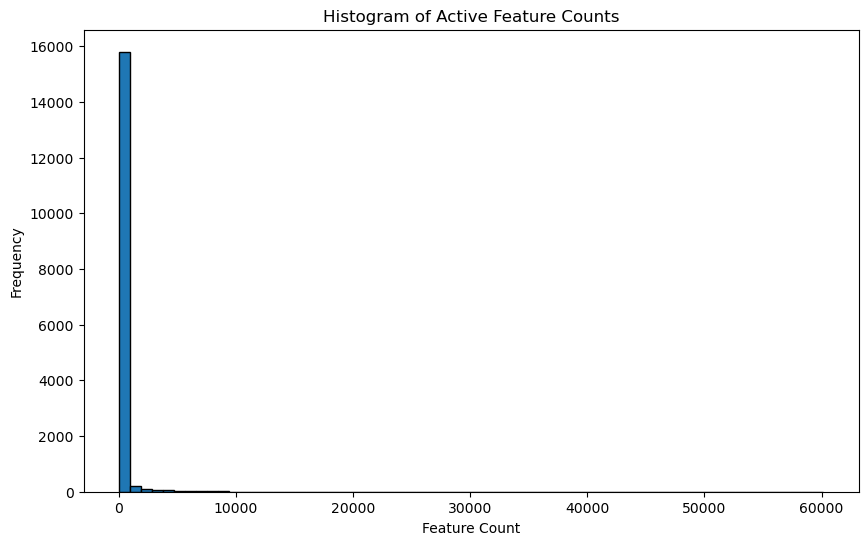

Report of Quartiles of Active Feature Counts:
1st Quartile (25th percentile): 0.0
2nd Quartile (Median, 50th percentile): 1.0
3rd Quartile (75th percentile): 29.0
Greatest Active Feature Count: 60154


In [31]:
active_feature_counts = tokenfeatures.active_feature_counts

plt.figure(figsize=(10, 6))
plt.hist(active_feature_counts.cpu().detach().numpy(), bins=64, edgecolor='black')
plt.xlabel('Feature Count')
plt.ylabel('Frequency')
plt.title('Histogram of Active Feature Counts')
plt.show()

import numpy as np

# Calculate quartiles
active_feature_counts_np = active_feature_counts.cpu().detach().numpy()
quartiles = np.percentile(active_feature_counts_np, [25, 50, 75])

# Generate report
print("Report of Quartiles of Active Feature Counts:")
print(f"1st Quartile (25th percentile): {quartiles[0]}")
print(f"2nd Quartile (Median, 50th percentile): {quartiles[1]}")
print(f"3rd Quartile (75th percentile): {quartiles[2]}")

# Get the greatest active feature count
greatest_active_feature_count = torch.max(active_feature_counts).item()
print(f"Greatest Active Feature Count: {greatest_active_feature_count}")



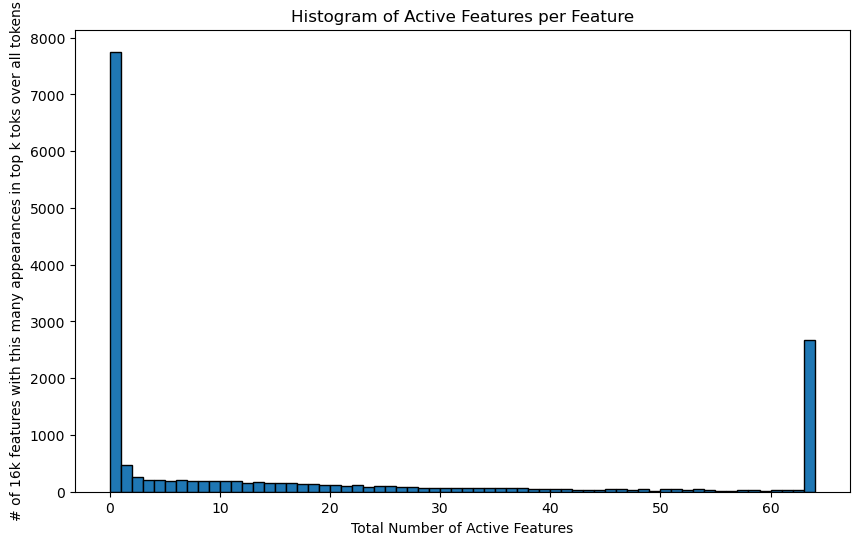

In [32]:
feature_strengths_topk = tokenfeatures.feature_strengths_top_k

active_features_mask = torch.where(feature_strengths_topk>0, torch.tensor(1), torch.tensor(0))

active_features_per_feature = active_features_mask.sum(dim=-1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(active_features_per_feature.cpu().detach().numpy(), bins=64, edgecolor='black')
plt.xlabel('Total Number of Active Features')
plt.ylabel('# of 16k features with this many appearances in top k toks over all tokens')
plt.title('Histogram of Active Features per Feature')
plt.show()


In [41]:
def analyze_feature_occurrences(n=20, occurrence_idx=0, tokens_around=5):
    # Get features which occur n times
    features_occurring_n_times = torch.where(active_features_per_feature == n)[0]
    # print(f"Features which occur {n} times: {features_occurring_n_times}")

    feature = features_occurring_n_times[occurrence_idx]
    print(f"Feature idx: {feature.item()}")

    locations, strengths = tokenfeatures.get_top_k_for_feature(feature)
    locations = torch.flip(locations, dims=[0])
    strengths = torch.flip(strengths, dims=[0])

    occurrence_strings = []

    for occurrence_idx in range(len(locations)):
        location = locations[occurrence_idx]
        list_idx = location[0]
        featuresequence_idx = location[1]

        # print(f"List Index: {list_idx}, featuresequence_idx: {featuresequence_idx}")

        # print("# lookup in all features")
        # print("- idx")
        # print(tokenfeatures.features[list_idx].view(-1)[featuresequence_idx])
        # print("- strength")
        # print(tokenfeatures.strengths[list_idx].view(-1)[featuresequence_idx])

        # get the token idx from the featuresequence idx:
        # print("# Location in tokens")
        token_idx = featuresequence_idx // num_features_per_token
        feature_idx = featuresequence_idx % num_features_per_token
        # print(f"Token Index: {token_idx}")
        # print(f"Feature Index: {feature_idx}")

        strength = tokenfeatures.strengths[list_idx][token_idx][feature_idx].item()
        feature_idx = tokenfeatures.features[list_idx][token_idx][feature_idx].item()

        token = tokenfeatures.token_lists[list_idx][token_idx]
        token_decoded = decode([token.item()])

        begin_idx = max(0, token_idx - tokens_around)
        end_idx = min(tokenfeatures.tokens_per_list, token_idx + tokens_around)

        sequence = tokenfeatures.token_lists[list_idx][begin_idx:end_idx]
        sequence_decoded = decode(sequence.tolist())

        occurrence_strings.append({
            "strength": strength,
            "feature_idx": feature_idx,
            "token_decoded": token_decoded,
            "sequence_decoded": sequence_decoded
        })

    return occurrence_strings

# Call the function
import json

# occurrence_strings = analyze_feature_occurrences(n=20, occurrence_idx=1, tokens_around=6) # fleeing
# occurrence_strings = analyze_feature_occurrences(n=20, occurrence_idx=5, tokens_around=6) # brothers = bears
occurrence_strings = analyze_feature_occurrences(n=10, occurrence_idx=3, tokens_around=10) # Fish/water/ocean
# occurrence_strings = analyze_feature_occurrences(n=30, occurrence_idx=2, tokens_around=6)
for occurrence_string in occurrence_strings:
    print(json.dumps(occurrence_string, indent=4))


Feature idx: 93
{
    "strength": 5.449701309204102,
    "feature_idx": 93,
    "token_decoded": " fish",
    "sequence_decoded": ", there was a fish named Nemo. Nemo loved to swim in the"
}
{
    "strength": 4.559823989868164,
    "feature_idx": 93,
    "token_decoded": " swim",
    "sequence_decoded": " to the beach and asked her mom if she could swim in the ocean. Her mom said to be"
}
{
    "strength": 3.8790228366851807,
    "feature_idx": 93,
    "token_decoded": " swim",
    "sequence_decoded": " But he kept trying until he finally learned how to swim. He was so proud when he could swim"
}
{
    "strength": 1.7782188653945923,
    "feature_idx": 93,
    "token_decoded": " swim",
    "sequence_decoded": " a girl who loved the sea. She loved to swim and explore its depths. Every day she"
}
{
    "strength": 0.7181594967842102,
    "feature_idx": 93,
    "token_decoded": " fish",
    "sequence_decoded": " never seen anything like it before!\n\nThe fish was very gentle and the boy c

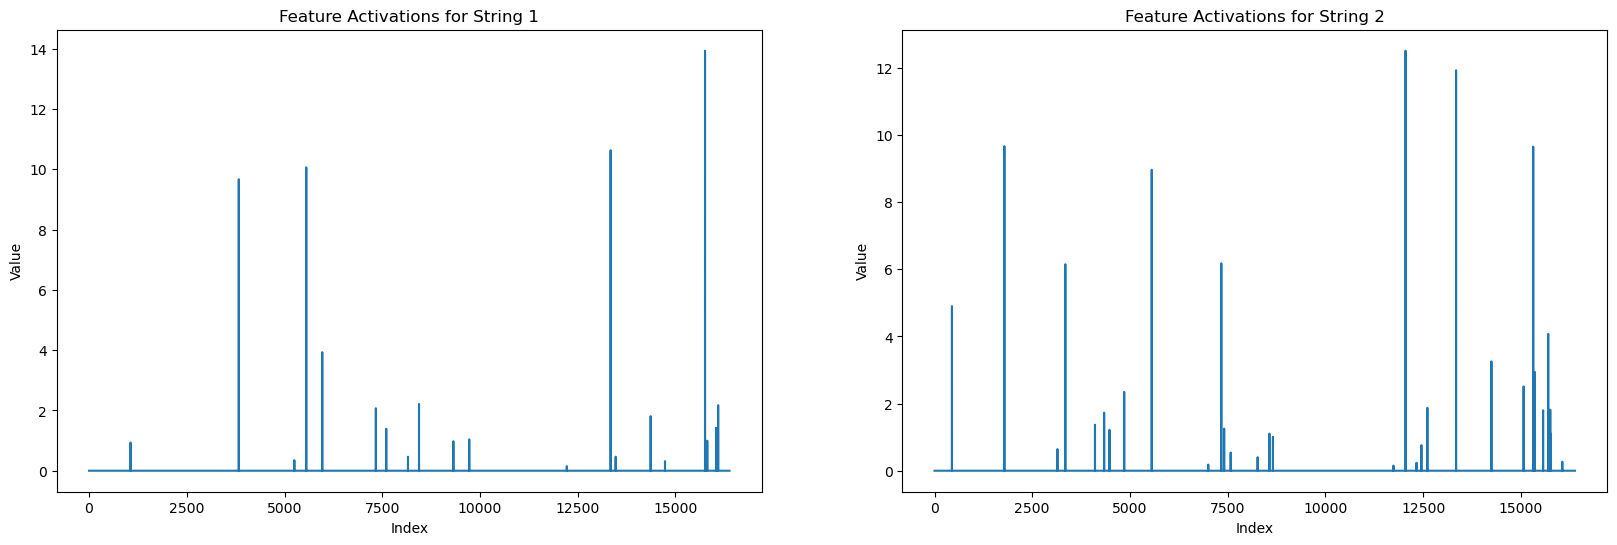

<Figure size 2000x600 with 0 Axes>

Number of overlapped top k features: 3
Number of active features for String 1: 24
Number of active features for String 2: 31


In [34]:


def process_input_string(input_string):
    embedding = model.get_embedding(input_string)


    sae_output = sae(embedding)
    encoded = sae_output['encoded']
    decoded = sae_output['decoded']
    feature_activations = sae_output['feature_activations']
    
    return encoded, decoded, feature_activations


string1 = "Cookies are yummy. They taste good."
string2 = "Cake tastes good. It is delicious"

encoded1, decoded1, feature_activations1 = process_input_string(string1)
encoded2, decoded2, feature_activations2 = process_input_string(string2)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(feature_activations1.cpu().detach().numpy())
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Activations for String 1')

plt.subplot(1, 2, 2)
plt.plot(feature_activations2.cpu().detach().numpy())
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Feature Activations for String 2')

plt.show()

plt.figure(figsize=(20, 6))

# plt.subplot(1, 2, 1)
# plt.plot(normalized_embedding1.cpu().detach().numpy())
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Normalized Embedding for String 1')

# plt.subplot(1, 2, 2)
# plt.plot(normalized_embedding2.cpu().detach().numpy())
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Normalized Embedding for String 2')

plt.show()


# get the top 50 features for each string
import torch

# Get the indexes of the top 50 features for each string
k = 20
top_k_features1 = torch.topk(feature_activations1, k).indices.cpu().detach().numpy()
top_k_features2 = torch.topk(feature_activations2, k).indices.cpu().detach().numpy()

# print("Top k features for String 1:", top_k_features1)
# print("Top k features for String 2:", top_k_features2)

# Find the intersection of the top k features for both strings
overlapped_features = set(top_k_features1).intersection(set(top_k_features2))

# Get the number of overlapped features
num_overlapped_features = len(overlapped_features)

print("Number of overlapped top k features:", num_overlapped_features)

# dot product of encoded1, encoded1

# normalize both encoded to have l2 norm of 1

# Print the number of active (nonzero) features for each string
num_active_features1 = torch.count_nonzero(feature_activations1).item()
num_active_features2 = torch.count_nonzero(feature_activations2).item()

print("Number of active features for String 1:", num_active_features1)
print("Number of active features for String 2:", num_active_features2)




In [35]:
def process_input_string(input_string):
    embedding = model.get_embedding(input_string)

    original = embedding
    sae_output = sae(embedding)
    encoded = sae_output['encoded']
    decoded = sae_output['decoded']
    feature_activations = sae_output['feature_activations']
    
    return original, encoded, decoded, feature_activations

string1 = "Lily climbed a tree."
string2 = "The dog was sad because it couldn't find his owner."

original1, encoded1, decoded1, feature_activations1 = process_input_string(string1)
original2, encoded2, decoded2, feature_activations2 = process_input_string(string2)

# Compute cosine similarity
cos_sim_original = F.cosine_similarity(original1.unsqueeze(0), original2.unsqueeze(0))
cos_sim_encoded = F.cosine_similarity(encoded1.unsqueeze(0), encoded2.unsqueeze(0))

print("Cosine Similarity Original:", cos_sim_original.item())
print("Cosine Similarity Encoded:", cos_sim_encoded.item())

Cosine Similarity Original: 0.7773996591567993
Cosine Similarity Encoded: 0.7823310494422913


# Evaluating Model $R^2$ and Percentage of features activated

In [36]:

a = torch.tensor([[1.25,2,3,4], # predicted example 1
                  [1.25,2.4,3.4,4.5]], dtype=torch.float32) # predicted example 2

b = torch.tensor([[1,   2,   3,   4  ], # actual example 1
                  [1.5, 2.5, 3.5, 4.5]], dtype=torch.float32) # actual example 2

def r2_per_channel(predicted, actual):
    channel_means = torch.mean(actual, dim=-2)
    avg_squared_error_per_channel = torch.mean((actual - channel_means)**2, dim=-2)
    avg_squared_error_predicted = torch.mean((predicted - actual)**2, dim=-2)
    return 1 - avg_squared_error_predicted / avg_squared_error_per_channel

print(r2_per_channel(a, b))

tensor([0.0000, 0.9200, 0.9200, 1.0000], device='cuda:0')


In [37]:
model_embedding_layer = 6

data = torch.load('tiny-stories-train.pt', map_location='cuda')


# torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y


# Assuming the rest of your code is unchanged and necessary imports and model definitions are already done

def calculate_r2(xb, yb, model, sae):
    tokens = xb
    embedding = model.forward(tokens, return_residuals=model_embedding_layer)
    decoded = sae(embedding)['decoded']
    r2 = r2_per_channel(predicted=decoded.view(-1, C), actual=embedding.view(-1, C))
    return r2.mean()

# Example usage
xb, yb = get_batch('train')  # Get a batch of data
r2_score = calculate_r2(xb, yb, model, sae)
print("R^2 Score:", r2_score)

R^2 Score: tensor(0.7638, device='cuda:0')


In [38]:

xb, yb = get_batch('train')
xb.shape[0]

8

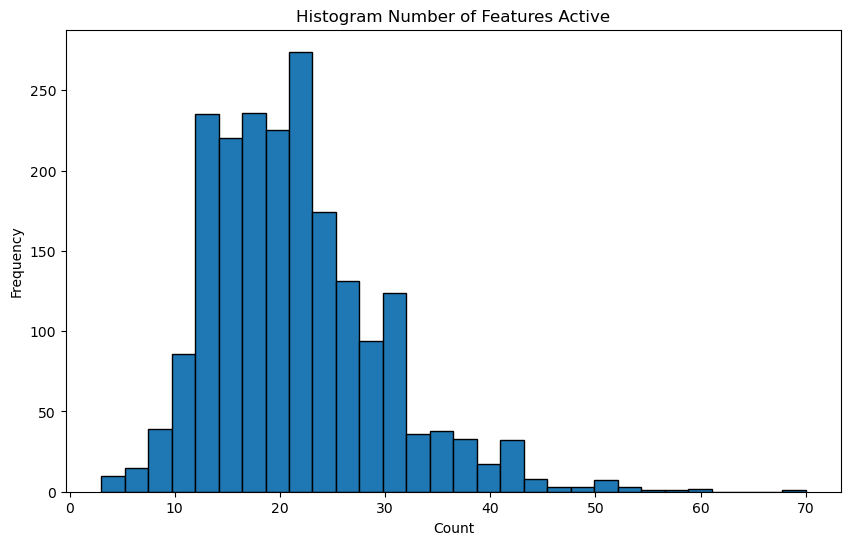

In [39]:
xb, yb = get_batch('train')
tokens = xb
embedding = model.forward(tokens, return_residuals=model_embedding_layer).view(-1, C)
sae_activations = sae(embedding)['feature_activations']

nonzero_counts = (sae_activations != 0)
features_active_per_token = nonzero_counts.sum(dim=1)


import matplotlib.pyplot as plt

# Plot histogram of random_counts
plt.figure(figsize=(10, 6))
plt.hist(features_active_per_token.cpu().detach().numpy(), bins=30, edgecolor='black')
plt.title('Histogram Number of Features Active')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()


# Sanity Check

text
"One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, ""Mom, I found this needle. Can you share it with 


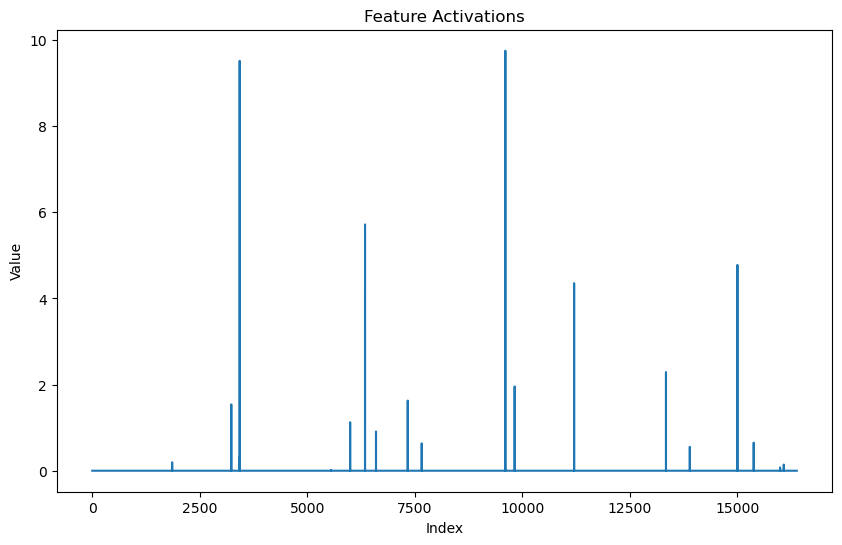

tensor(19, device='cuda:0')


In [40]:
start_idx = 0
characters = 300

text = text[start_idx:start_idx+characters]
print(text)

embedding =  model.get_embedding(text)

sae_output = sae(embedding)

features = sae_output['feature_activations']

import matplotlib.pyplot as plt

# Plot the feature activations
plt.figure(figsize=(10, 6))
plt.plot(features.cpu().detach().numpy().flatten())
plt.title('Feature Activations')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

nonzero_counts = (features != 0.0)
print(nonzero_counts.sum())


# Data Struct